In [ ]:
!mkdir dataset

In [ ]:
import zipfile
import os

zip_path = '/content/dataset/periodontal_disease.zip'
extract_to = '/content/dataset'

def extract_zip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"File diekstraksi ke: {extract_to}")

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

extract_zip_file(zip_path, extract_to)

os.remove(zip_path)

File diekstraksi ke: /content/dataset


In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Ganti '3' dengan jumlah kelas Anda

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/train',  # Ganti dengan path ke data training
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/val',  # Ganti dengan path ke data validasi
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 132 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.6123 - loss: 0.7013 - val_accuracy: 0.6364 - val_loss: 0.6655
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.6260 - loss: 0.7059 - val_accuracy: 0.6364 - val_loss: 0.6830
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4815 - loss: 0.7997 - val_accuracy: 0.6364 - val_loss: 0.7575
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5990 - loss: 0.7836 - val_accuracy: 0.6364 - val_loss: 0.6563
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5647 - loss: 0.6870 - val_accuracy: 0.6364 - val_loss: 0.6780
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5051 - loss: 0.7821 - val_accuracy: 0.6364 - val_loss: 0.6615
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4621 - loss: 0.7890 - val_accuracy: 0.6364 - val_loss: 0.7001
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6026 - loss: 0.8639 - val_accuracy: 0.6364 - val_loss: 0.6669
Epoch

In [ ]:
model.save('periodontal_disease_model_resnet50.h5')

In [ ]:
model = tf.keras.models.load_model('periodontal_disease_model_resnet50.h5')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/test',  # Ganti dengan path ke data uji
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator)


Found 44 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

true_labels = test_generator.classes

predicted_labels = np.argmax(predictions, axis=1)

print('Classification Report')
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(true_labels, predicted_labels))


Classification Report
              precision    recall  f1-score   support

inflammation       0.64      1.00      0.78        28
      normal       0.00      0.00      0.00        16

    accuracy                           0.64        44
   macro avg       0.32      0.50      0.39        44
weighted avg       0.40      0.64      0.49        44

Confusion Matrix
[[28  0]
 [16  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(checkpoint_path).expect_partial()


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Ganti '3' dengan jumlah kelas Anda

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/train',  # Ganti dengan path ke data training
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/val',  # Ganti dengan path ke data validasi
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 132 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)


Epoch 1/30
5/5 [==============================] - 21s 5s/step - loss: 0.7281 - accuracy: 0.5227 - val_loss: 0.6606 - val_accuracy: 0.6364
Epoch 2/30
5/5 [==============================] - 2s 420ms/step - loss: 0.7004 - accuracy: 0.6061 - val_loss: 0.6598 - val_accuracy: 0.6364
Epoch 3/30
5/5 [==============================] - 2s 414ms/step - loss: 0.6905 - accuracy: 0.5985 - val_loss: 0.6587 - val_accuracy: 0.6364
Epoch 4/30
5/5 [==============================] - 2s 428ms/step - loss: 0.6578 - accuracy: 0.6439 - val_loss: 0.6584 - val_accuracy: 0.6364
Epoch 5/30
5/5 [==============================] - 2s 593ms/step - loss: 0.6736 - accuracy: 0.6136 - val_loss: 0.6600 - val_accuracy: 0.6364
Epoch 6/30
5/5 [==============================] - 3s 504ms/step - loss: 0.6639 - accuracy: 0.5985 - val_loss: 0.6617 - val_accuracy: 0.6364
Epoch 7/30
5/5 [==============================] - 2s 427ms/step - loss: 0.6528 - accuracy: 0.6136 - val_loss: 0.6639 - val_accuracy: 0.6364
Epoch 8/30
5/5 [======

In [ ]:
model.save('periodontal_disease_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model yang sudah dilatih
model = tf.keras.models.load_model('periodontal_disease_model.h5')

# Persiapkan generator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/periodontal_disease/test',  # Ganti dengan path ke data uji
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Menghasilkan prediksi
predictions = model.predict(test_generator)


Found 44 images belonging to 2 classes.
2/2 [==============================] - 1s 155ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Mendapatkan label sebenarnya
true_labels = test_generator.classes

# Mendapatkan label prediksi
predicted_labels = np.argmax(predictions, axis=1)

# Menghasilkan laporan klasifikasi
print('Classification Report')
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

# Menghasilkan confusion matrix
print('Confusion Matrix')
print(confusion_matrix(true_labels, predicted_labels))


Classification Report
              precision    recall  f1-score   support

inflammation       0.64      1.00      0.78        28
      normal       0.00      0.00      0.00        16

    accuracy                           0.64        44
   macro avg       0.32      0.50      0.39        44
weighted avg       0.40      0.64      0.49        44

Confusion Matrix
[[28  0]
 [16  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


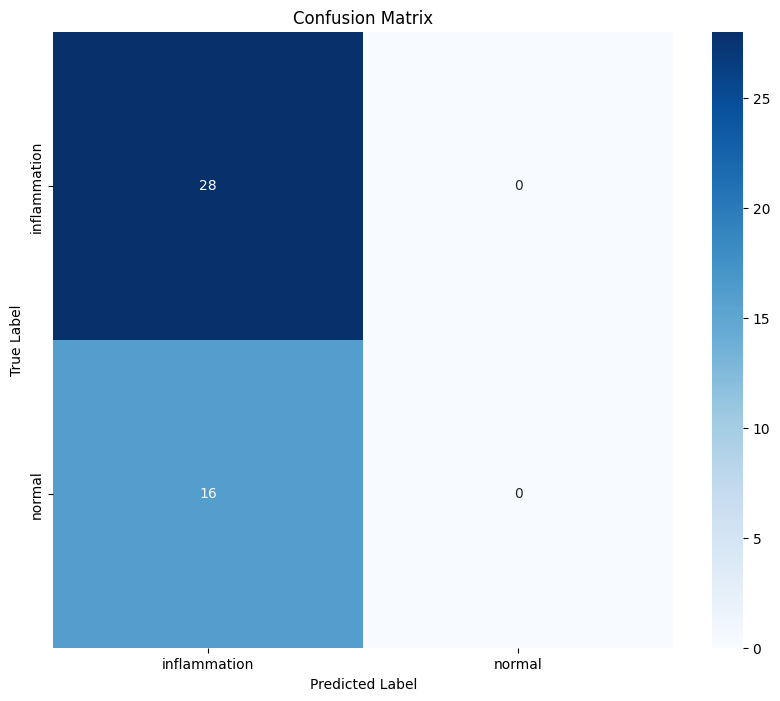

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
